# Bayesian Neural Network in Turing.jl

Load packages.

In [1]:
using Turing, PyPlot, Random

Generate some data points.

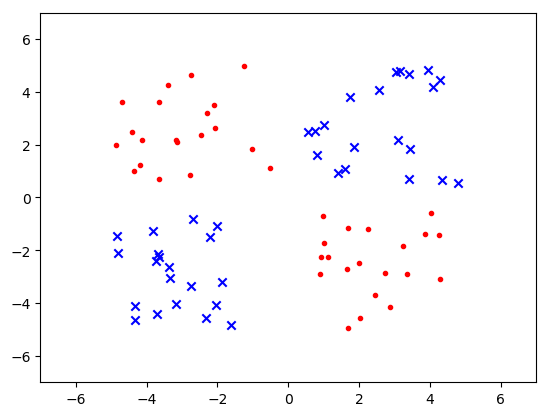

In [2]:
N = 80; M = round(Int, N / 4); Random.seed!(1234)

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

xs = [xt1s; xt0s]; ts = [ones(2*M); zeros(2*M)]

# Plot data points
function plot_data()
    scatter(map(e -> e[1], xt1s), map(e -> e[2], xt1s), marker="x", color="blue")
    scatter(map(e -> e[1], xt0s), map(e -> e[2], xt0s), marker=".", color="red")
    xlim([-7, 7]); ylim([-7, 7])
end

plot_data()
;

Define the sigmoid function $$ f(x) = 1 / (1 + e^{-x}) $$ for later use.

In [3]:
sigmoid(x::Real) = 1 ./ (1 + exp(-x))
;

Define a feed forward neural network shown in the diagram.

<img width="33%" src="nn-diagram.png">

In [4]:
nn_forward(x, W₁, b₁, W₂, b₂, wₒ, bₒ) = begin
    h₁ = tanh.(W₁' * x + b₁)
    h₂ = tanh.(W₂' * h₁ + b₂)
    sigmoid.(wₒ' * h₂ + bₒ)
end
;

Define a Bayes NN in Turing.jl.

In [5]:
alpha = 0.09            # regularizatin term
sig = sqrt(1.0 / alpha) # variance of the Gaussian prior

@model bayes_nn(xs, ts) = begin
    W₁ = Matrix{Real}(undef, 2, 3)
    W₁ ~ [MvNormal(zeros(2), sig * ones(2))]
    b₁ ~ MvNormal(zeros(3), sig * ones(3))

    W₂ = Matrix{Real}(undef, 3, 2)
    W₂ ~ [MvNormal(zeros(3), sig * ones(3))]
    b₂ ~ MvNormal(zeros(2), sig * ones(2))

    wₒ ~ MvNormal(zeros(2), sig * ones(2))
    bₒ ~ Normal(0, sig)
    
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(nn_forward(xs[i], W₁, b₁, W₂, b₂, wₒ, bₒ)[1])
    end
end
;

Run inference.

In [6]:
N = 2000
ch = sample(bayes_nn(xs, ts), HMC(N, 0.05, 4))
;

┌ Info:  Assume - `W₁` is a parameter
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:135
┌ Info:  Assume - `b₁` is a parameter
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:135
┌ Info:  Assume - `W₂` is a parameter
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:135
┌ Info:  Assume - `b₂` is a parameter
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:135
┌ Info:  Assume - `wₒ` is a parameter
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:135
┌ Info:  Assume - `bₒ` is a parameter
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:135
┌ Info:  Observe - `ts` is an observation
└ @ Turing /Users/kai/.julia/dev/Turing/src/core/compiler.jl:153
[HMC] Sampling...  0%  ETA: 2:17:32
  ϵ:         0.05
  α:         0.8798127266732926
[HMC] Sampling...  5%  ETA: 0:01:47.0,...
  ϵ:         0.05
  α:         0.9755968571047215
[HMC] Sampling...  9%  ETA: 0:01:05.0,...
  ϵ:         0.05
  α:         1.0
[HMC] Sampling... 13

[HMC] Finished with
  Running time        = 29.331738803000018;
  Accept rate         = 0.916;
  #lf / sample        = 3.998;
  #evals / sample     = 5.9975;
  pre-cond. diag mat  = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,....


[HMC] Sampling...100% Time: 0:00:29


Define some helper functions and convert data format for plotting.

In [7]:
na2mat(na) = begin
    ncol = length(na); nrow = length(na[1])
    mat = Matrix{eltype(na[1])}(undef, nrow, ncol)
    for n = 1:ncol mat[:, n] = na[n] end
    mat
end

b₁ = ch[:b₁]; W₁ = map(na->na2mat(na), ch[:W₁])
b₂ = ch[:b₂]; W₂ = map(na->na2mat(na), ch[:W₂])
bₒ = ch[:bₒ]; wₒ = ch[:wₒ]
;

## MAP estimation

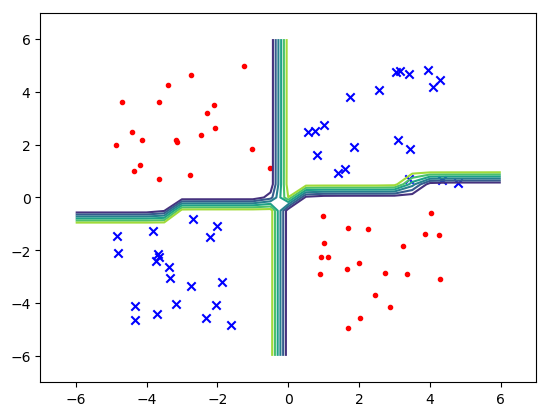

In [8]:
plot_data()

_, i = findmax(ch[:lp]) # find sample with max lp in chain

xs = collect(range(-6,stop=6,length=25))
ys = collect(range(-6,stop=6,length=25))
Z = [nn_forward([x, y], W₁[i], b₁[i], W₂[i], b₂[i], wₒ[i], bₒ[i])[1] for x=xs, y=ys]
contour(xs, ys, Z)
;

Now we can do visualization by Bayesian prediciton.

$$ p(\tilde{x} | X, \alpha) = \int_{\theta} p(\tilde{x} | \theta) p(\theta | X, \alpha) \approx \sum_{\theta \sim p(\theta | X, \alpha)}f_{\theta}(\tilde{x}) $$

In [9]:
function nn_predict(x, W₁, b₁, W₂, b₂, Wₒ, bₒ, n_end)
    mean([nn_forward(x, W₁[i], b₁[i], W₂[i], b₂[i], wₒ[i], bₒ[i])[1] for i in 1:10:n_end])
end

nn_predict (generic function with 1 method)

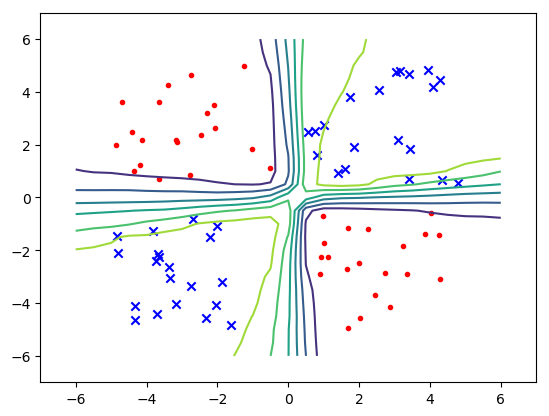

In [10]:
plot_data()

n_end = 1500
xs = collect(range(-6,stop=6,length=25))
ys = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], W₁, b₁, W₂, b₂, wₒ, bₒ, n_end)[1] for x=xs, y=ys]
contour(xs, ys, Z)
;

Let's build an interactive plot.

In [11]:
# @manipulate for n_end = 10:10:N
#     p_layer = layer(z=(x,y) -> nn_predict([x, y], W₁, b₁, W₂, b₂, wₒ, bₒ, n_end), 
#                     x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)
#     plot(d1_layer, d2_layer, p_layer, 
#          Coord.cartesian(xmin=-6, xmax=6, ymin=-6, ymax=6),
#          Guide.title("Bayes prediciton using first $n_end samples"))
# end
# ;